In [29]:
# Input from wav file

import wave
import array

#wf = wave.open('../data/Microwave finish (fan background).wav', 'rb')
wf = wave.open('../data/Washing machine finish.wav', 'rb')

data = wf.readframes(wf.getnframes())

input_framerate = wf.getframerate()
vals = array.array('H', data)


In [30]:
# Downsample to reduce data, based on max frequency

from scipy.signal import resample
from math import floor

max_capture_frequency = 5_000
min_capture_freqency = 50

target_framerate = max_capture_frequency * 2
target_samples = floor(len(vals) * target_framerate / input_framerate)

vals_ds = resample(vals, target_samples)

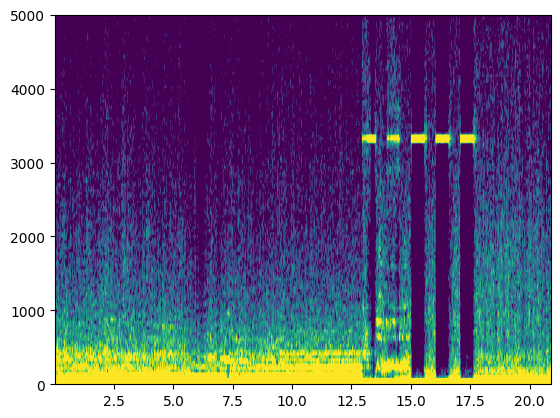

In [31]:
from matplotlib import pyplot as plt

_ = plt.specgram(vals_ds, Fs=target_framerate, vmin=40, vmax=60)

In [32]:
# Extract excerpt of interest

from math import floor

start_timestamp = 12.8
start_i_sample = floor(start_timestamp * target_framerate)

excerpt_duration = 7.0
excerpt_n_samples = floor(excerpt_duration * target_framerate)

excerpt_vals = vals_ds #vals_ds[start_i_sample:start_i_sample + excerpt_n_samples]

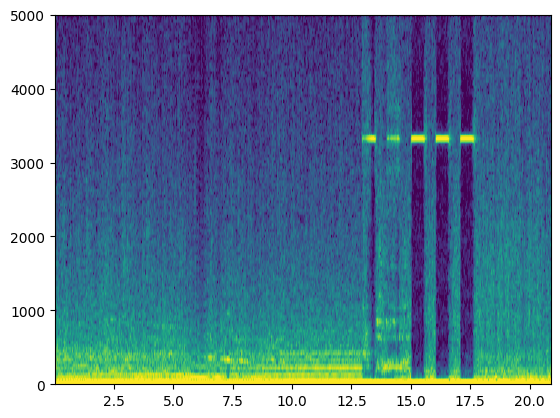

In [33]:
from matplotlib import pyplot as plt

_ = plt.specgram(excerpt_vals, Fs=target_framerate, vmin=30, vmax=70)

In [34]:
# Perform FFT on each chunk

from scipy.signal import spectrogram
import numpy as np

chunk_n_samples = 256 # Use power of two to maximise FFT performance
chunk_duration = chunk_n_samples / target_framerate

print(f"Chunk duration is {chunk_duration*1e3}ms")

f, t, chunks_spec = spectrogram(
  excerpt_vals,
  fs=target_framerate,
  nperseg=chunk_n_samples,
  noverlap=0
)

chunks_spec = 10*np.log10(chunks_spec)

Chunk duration is 25.6ms


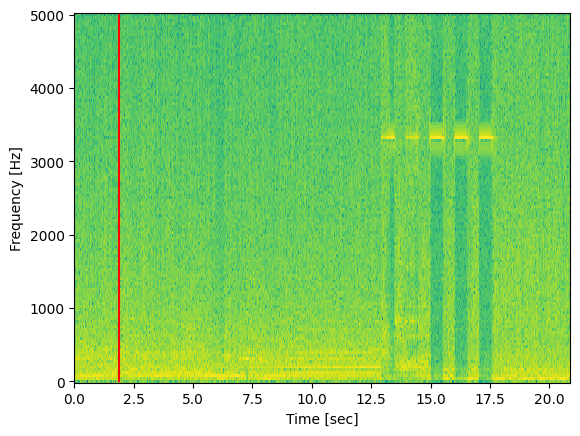

In [35]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

i_analyse = 73
t_analyse = t[i_analyse]

fig, ax = plt.subplots()

ax.pcolormesh(t, f, chunks_spec)
ax.add_line(Line2D([t_analyse, t_analyse], [0, 5000], color="#F00"))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.show()


In [36]:
from scipy.signal import find_peaks
import numpy as np

chunks_freqs = np.transpose(chunks_spec)
chunks_peaks = [find_peaks(chunk_freqs, prominence=20, distance=10) for chunk_freqs in chunks_freqs]

chunks_peak_analyse = chunks_peaks[i_analyse][0]

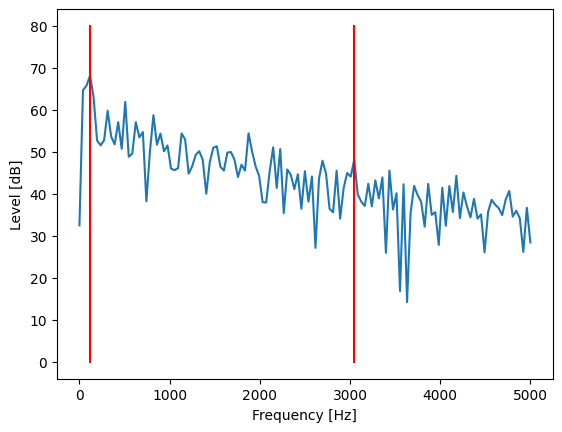

In [37]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

fig, ax = plt.subplots()

ax.plot(f, chunks_freqs[i_analyse], 10)
for peak in chunks_peak_analyse:
  peak_f = f[peak]
  ax.add_line(Line2D([peak_f, peak_f], [0, 80], color="#F00"))
plt.ylabel('Level [dB]')
plt.xlabel('Frequency [Hz]')

plt.show()

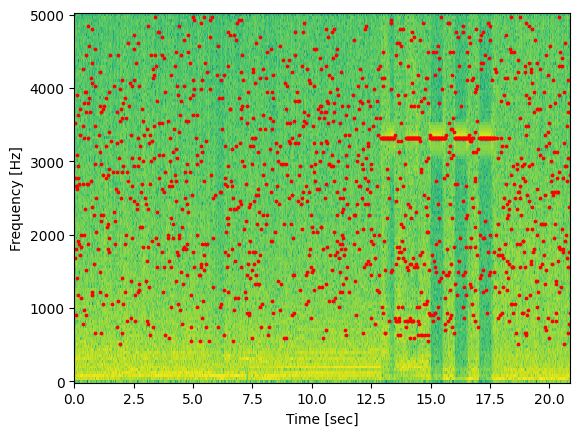

In [38]:


from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np

chunks_peaks_freqs = [[f[peak] for peak in chunk_peaks] for chunk_peaks, _ in chunks_peaks]

xs = []
ys = []
for i in range(len(chunks_peaks_freqs)):
  for p in chunks_peaks_freqs[i]:
    if p > 500:
      xs.append(t[i])
      ys.append(p)

fig, ax = plt.subplots()

ax.pcolormesh(t, f, chunks_spec)
ax.scatter(xs, ys, s=3, c="#F00")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.show()

In [39]:
fingerprint_microwave = [
  {
    'type': 'sine',
    'frequency': 2030,
    'start_ms': 0, # sample 65
    'end_ms': 250 # sample 74
  }
]

In [43]:
import numpy as np
from scipy.fft import rfftfreq, rfft
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from matplotlib.lines import Line2D
import logging as log
from math import floor
from timeit import default_timer as timer
from datetime import datetime

PROMINENCE = 10 # Min prominence for detecting local peak
DISTANCE = 10 # Min distance of peak from adjacent peaks
CHUNK_LENGTH = 256
SAMPLE_RATE = 10000

MATCH_FREQUENCY_TOLERANCE = 0.03 # Tolerance of matching fingerprint frequency as multiple of frequency to match
MATCH_TIME_TOLERANCE = 2 # Tolerance of matching fingerprint timing in chunks

def ms_to_chunks(ms):
  return floor(ms * SAMPLE_RATE / 1000 / CHUNK_LENGTH)

fs = rfftfreq(CHUNK_LENGTH) * target_framerate # type: ignore
fs = fs[fs > 0]

fingerprints = {
  "microwave": {
    'repetitions': 5,
    'max_period_ms': 1000,
    'pattern':
      [
        {
          'type': 'sine',
          'frequency': 2030,
          'start_chunk': ms_to_chunks(0), # sample 65
          'end_chunk': ms_to_chunks(150) # sample 74
        },
        {
          'type': 'any',
          'start_chunk': ms_to_chunks(151),
          'end_chunk': ms_to_chunks(400)
        }
      ]
  },
  "washing": {
    'repetitions': 5,
    'max_period_ms': 1400,
    'pattern':
      [
        {
          'type': 'sine',
          'frequency': 3300,
          'start_chunk': ms_to_chunks(0), # sample 65
          'end_chunk': ms_to_chunks(400) # sample 74
        },
        {
          'type': 'any',
          'start_chunk': ms_to_chunks(401),
          'end_chunk': ms_to_chunks(800)
        }
      ]
  }
}


def pattern_to_chunkmap(pattern):
  chunkmap = []
  aggregate_start_chunk = min([phase['start_chunk'] for phase in pattern])
  aggregate_end_chunk = max([phase['end_chunk'] for phase in pattern])

  for i_chunk in range(aggregate_start_chunk, aggregate_end_chunk):
    relevant_phases = [p for p in pattern if p['start_chunk'] <= i_chunk and p['end_chunk'] > i_chunk]
    for phase in relevant_phases:
      phase_type = phase['type']
      chunk_freqs = []
      if phase_type == 'sine':
        chunk_freqs.append(phase['frequency'])
      elif phase_type == 'any':
        pass
      else:
        raise ValueError(f'Phase has unrecognised type "{phase_type}"')
      
      chunkmap.append(chunk_freqs)
    
  return chunkmap

def matches_chunkmap_at_index_with_tolerance(chunkmap, freq_tolerance, chunk_tolerance, index, frequencies):
  if len(chunkmap[index]) == 0:
    return True
  
  start_i_chunk = max(0, index-chunk_tolerance)
  end_i_chunk = min(index+chunk_tolerance+1, len(chunkmap))

  for i in range(start_i_chunk, end_i_chunk):
    if matches_chunkmap_at_index(chunkmap, freq_tolerance, i, frequencies):
      return True
    
  return False

def matches_chunkmap_at_index(chunkmap, freq_tolerance, index, frequencies):
  expected_freqs = chunkmap[index]
  
  if len(expected_freqs) == 0:
      return True  

  matched_freqs = 0
  for actual_freq in frequencies:
    for expected_freq in expected_freqs:
      if np.isclose(actual_freq, expected_freq, rtol=freq_tolerance):
        matched_freqs += 1
        if matched_freqs == len(expected_freqs):
          return True
        
  return False

  
chunkmaps = { k: pattern_to_chunkmap(f['pattern']) for k, f in fingerprints.items() }
match_progress = {
  k:
    {
      'repetition': 0,
      'chunk': 0,
      'chunks_since_last_repetition': 0,
      'max_chunks_since_last_repetition': ms_to_chunks(f['max_period_ms']),
      'accumulated_errors': 0
    } for k, f in fingerprints.items()
  } # type: ignore

print(chunkmaps)

match_events = []

def process_chunk(samples, t=None):
  start_time = timer()
  if samples.size != CHUNK_LENGTH:
    log.warning(f"Received a chunk containing {samples.size} samples which does not match expected length of {CHUNK_LENGTH}")
  
  freq_vals = np.absolute(rfft(samples)[1:]) # type: ignore
  freq_db = 10*np.log10(freq_vals) # type: ignore

  freq_peaks_i = find_peaks(freq_db, prominence=PROMINENCE, distance=DISTANCE)[0]
  freq_peaks = [fs[peak] for peak in freq_peaks_i]

  # Do matching

  for k, progress in match_progress.items():
    # Stage continues
    chunkmap = chunkmaps[k]
    
    # The chunk we're looking for would come within the time limit

    matched = matches_chunkmap_at_index(
      chunkmap,
      MATCH_FREQUENCY_TOLERANCE,
      progress['chunk'],
      freq_peaks
    )

    missed_within_tolerance = not matched and progress['chunk'] > 0 and progress['accumulated_errors'] < MATCH_TIME_TOLERANCE
    if missed_within_tolerance:
      # Chunk is not a match but within tolerance
      progress['accumulated_errors']  += 1

    if matched:
      progress['accumulated_errors'] = 0

    if matched or missed_within_tolerance:
      # Chunk is as good as a match
      if progress['chunk'] >= len(chunkmap) - 1:
        # Entire chunkmap has been matched -> Phase match completed!
        progress['chunk'] = 0
        progress['repetition'] += 1
        progress['chunks_since_last_repetition'] = 0
      else:
        # Look for next match
        progress['chunk'] += 1
        progress['chunks_since_last_repetition'] += 1
    elif progress['repetition'] > 0 and progress['chunks_since_last_repetition'] <= progress['max_chunks_since_last_repetition']:
      # Chunk is not a match but it's not too late to hit the next phase
      progress['chunk'] = 0
      progress['chunks_since_last_repetition'] += 1
      progress['accumulated_errors']  = 0
    else:
      # No match and no more phases
      progress['chunk'] = 0
      progress['accumulated_errors']  = 0
      progress['chunks_since_last_repetition'] = 0
      progress['repetition'] = 0
    
    if progress['repetition'] == fingerprints[k]['repetitions']:
      # Fingerpring match completed!
      match_events.append({
        'time': datetime.now(),
        'fingerprint': k
      })

      progress['chunk'] = 0
      progress['repetition'] = 0
      progress['chunks_since_last_repetition'] = 0
      progress['accumulated_errors']  = 0

  end_time = timer()
  duration_ms = (end_time - start_time) * 1e3

  print({
    "matched": matched,
    "t": t,
    "duration": duration_ms,
    "match_progress": match_progress,
    "peak_f": freq_peaks
  })

  
  ## Plot

  

    # fig, ax = plt.subplots()

    # ax.plot(fs, freq_db, 10)
    # for peak in freq_peaks:
    #   ax.add_line(Line2D([peak, peak], [0, 80], color="#F00"))
    # plt.ylabel('Level [dB]')
    # plt.xlabel('Frequency [Hz]')
    # plt.title(f'Duration {duration_ms:.2f}ms, matched: {matched}')

    # plt.show()



i_sample = 63 * CHUNK_LENGTH
while i_sample < len(vals_ds):
  process_chunk(vals_ds[i_sample:i_sample + CHUNK_LENGTH], t=i_sample/SAMPLE_RATE)
  i_sample += CHUNK_LENGTH

print(match_events)

{'microwave': [[2030], [2030], [2030], [2030], [2030], [], [], [], [], [], [], [], [], [], []], 'washing': [[3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [3300], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]}
{'matched': False, 't': 1.6128, 'duration': 0.6065090001357021, 'match_progress': {'microwave': {'repetition': 0, 'chunk': 0, 'chunks_since_last_repetition': 0, 'max_chunks_since_last_repetition': 39, 'accumulated_errors': 0}, 'washing': {'repetition': 0, 'chunk': 0, 'chunks_since_last_repetition': 0, 'max_chunks_since_last_repetition': 54, 'accumulated_errors': 0}}, 'peak_f': [2578.125, 3710.9375]}
{'matched': False, 't': 1.6384, 'duration': 0.29545500001404434, 'match_progress': {'microwave': {'repetition': 0, 'chunk': 0, 'chunks_since_last_repetition': 0, 'max_chunks_since_last_repetition': 39, 'accumulated_errors': 0}, 'washing': {'repetition': 0, 'chunk': 0, 'chunks_since_last_repetition': 0, 

{'matched': False, 't': 20.48, 'duration': 2.4173479996534297, 'match_progress': {'microwave': {'repetition': 0, 'chunk': 0, 'chunks_since_last_repetition': 0, 'max_chunks_since_last_repetition': 39, 'accumulated_errors': 0}, 'washing': {'repetition': 0, 'chunk': 0, 'chunks_since_last_repetition': 0, 'max_chunks_since_last_repetition': 54, 'accumulated_errors': 0}}, 'peak_f': [1289.0625, 4296.875]}
{'matched': False, 't': 20.5056, 'duration': 0.5866010005775024, 'match_progress': {'microwave': {'repetition': 0, 'chunk': 1, 'chunks_since_last_repetition': 1, 'max_chunks_since_last_repetition': 39, 'accumulated_errors': 0}, 'washing': {'repetition': 0, 'chunk': 0, 'chunks_since_last_repetition': 0, 'max_chunks_since_last_repetition': 54, 'accumulated_errors': 0}}, 'peak_f': [664.0625, 2070.3125]}
{'matched': False, 't': 20.5312, 'duration': 0.18941600046673557, 'match_progress': {'microwave': {'repetition': 0, 'chunk': 2, 'chunks_since_last_repetition': 2, 'max_chunks_since_last_repetiti